In [3]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import seaborn as sns

sns.set_theme(font_scale=1.7, style='whitegrid')

# Esercitazione 3

## 0 - Appunti e introduzione

Nella scorsa lezione abbiamo introdotto alcune strategie per aumentare le performance dei codici scritti in `Python`, tra cui in particolare utilizziamo numba. 

Estendere il `back-end` utilizzando altre strategie è importante. Se necessito una fz molto performante su `tf` posso, ad esempio, scriverla in `C++` e poi fornirla a `tf`.

#### Che framework scegliere?

Ci sono un sacco di opzioni. Diciamo che `tf` è il più utilizzato tra tutti. Seguono `keras` e `PyTorch`. Per scegliere conviene analizzare _learning curve, developement pace, community size, papers associate al framework (tf ad esempio consente agli utenti di interagire ed aprire degli issues su GitHub), stabilità nel tempo e performance_.

---

### Su TensorFlow

#### Variabili e tensori

Posso decidere dove e come allocare la memoria. se scrivo `with tf.device('CPU:0')` sto scegliendo la CPU. Alternativamente `same... ('GPU:0')`.

- `tf.Variable` è una variabile il cui valore è modificabile in futuro utilizzando `tf.assign()`;
- `tf.constant` è una variabile il cui valore viene mantenuto costante.

In `C++` non potrei fare questa operazione in meno di 50 righe.

#### Gradienti

Utilizzando `GradientTape` tf interpreta il gradiente della formula funzionale. 

HP di avere un modello lineare, in cui definisco una matrice di pesi e una di bias:

In [16]:
w = tf.Variable(tf.random.normal((3,2)), name='w')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
x = [[1.,2.,3.]]

In [17]:
with tf.GradientTape() as tape:
    y = tf.nn.sigmoid(x @ w + b)
    loss = tf.reduce_mean(tf.math.square(y))

Abbiamo costruito una loss che è una catena di operazioni. Abbiamo in qualche modo costruito un algoritmo di stocastic gradient descent in completa autonomia. Nelle slide fa un esempio di training su quattro variabili in cui si vede come il `tape` vada a tener conto solo di quelle che rimangono a tutti gli effetti delle `Variable`.

In [18]:
[dl_dw, dl_db] = tape.gradient(loss, [w, b])

In [19]:
print(dl_dw, dl_db)

tf.Tensor(
[[0.00206387 0.00033378]
 [0.00412774 0.00066756]
 [0.00619162 0.00100134]], shape=(3, 2), dtype=float32) tf.Tensor([0.00206387 0.00033378], shape=(2,), dtype=float32)


#### tf Module
Possiamo costruire una classe (di seguito alcune note utili se, come me, sei nabb*):

- `__init__` è un costruttore. Metodo invocato automaticamente nel momento in cui si va definire un oggetto che corrisponde alla classe in esame. Contiene i vari data membri, che verranno richiamati tramite il prefisso `self.`;
- `super()` invoca la classe madre quando stiamo programmando utilizzando ereditareità nelle classi. Può essere usato per evitare di ricordarsi il nome della super-classe.

In [24]:
class SimpleModule(tf.Module):
    
    #costruttore 
    def __init__(self, name=None):
        super().__init__(name=name)
        self.a_variable = tf.Variable(5.0, name='train_me')
        self.non_trainable_variable = tf.Variable(5.0, trainable=False)
    
    #azione in chiamata della classe
    def __call__(self, x):
        return self.a_variable * x + self.non_trainable_variable

In [25]:
simple_module = SimpleModule(name="simple")
simple_module(tf.constant(5.0))

<tf.Tensor: shape=(), dtype=float32, numpy=30.0>

In [28]:
# se voglio costruire un layer dense

class Dense(tf.Module):
    
    #costruttore
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name='w')
        self.b = tf.Variable(tf.zeros([out_feature]), name='b')
    
    # azione in chiamata della classe
    def __call__(self, x):
        y = tf.matmul(x, self.w) + self.b
        return tf.nn.relu(y)

---

### Su Keras

Keras rientra nel mondo del high-level. Oggi è un modulo di `tf` che lavora come API. Un esempio di costruzione tramite Keras:

In [34]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(2, activation="relu"))
model.add(tf.keras.layers.Dense(3, activation="relu"))
model.add(tf.keras.layers.Dense(1))
# ora la rete è inizializzata in modo casuale dal framework
# se la alleniamo questa si adegua ai pattern del mio campione
# però già così una risposta me la da, casuale ma me la da

y = model(tf.ones((1,1)))
model.summary()

y

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (1, 2)                    4         
_________________________________________________________________
dense_13 (Dense)             (1, 3)                    9         
_________________________________________________________________
dense_14 (Dense)             (1, 1)                    4         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>

A questo punto abbiamo due metodi necessari all'utilizzo della rete:

1. `model.compile()` compila la rete;
2. `model.fit()` la allena.

Questa tecnica sequenziale potrebbe non essere sempre utile. Ad esempio quando:

- abbiamo output e input multipli;
- ogni layer ha multiple inputs and outputs;
- vogliamo condivisione tra i layers;
- vogliamo una topologia non lineare.

Ecco che entra in gioco la __API funzionale__. Usando tf dichiariamo un input e indichiamo la shape. A questo punto definiamo i layers separatamente e passiamo manualmente come input degli strati successivi gli output dei precedenti:

In [40]:
inputs = tf.keras.Input(shape=(5,))
x1 = tf.keras.layers.Dense(64, activation='relu')(inputs)
x2 = tf.keras.layers.Dense(64, activation='relu')(x1)
outputs = tf.keras.layers.Dense(1)(x2)

# e adesso trasformo la mia struttura in un modulo standard, così posso usare i metodi
# compile e fit dalla stessa API vista prima

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="MyModel")
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD())

# e se carico anche i dataset a questo punto posso eseguire il training
#history = model.fit(x_train, y_train, batch_size=32, epochs=100)

# e poi valutare il modello con evaluate(x_test, y_test)

## 1 - MLP

Per questo primo esercizio costruisco una classe che chiamo simpleMLP.

In --> h1 --> h2 --> Out

In [226]:
x = np.linspace(-1, 1, 10, dtype=np.float32).reshape(-1, 1)

In [227]:
tf.random.set_seed(0)

class simpleMLP:
    
    # costruisco tutti i pesi nella rete
    def __init__(self, n_input, n_output, n_hidden_1, n_hidden_2):
        # In --> h1    
        self.w1 = tf.Variable(tf.random.normal([n_input, n_hidden_1]), name='w1')
        self.b1 = tf.Variable(tf.random.normal([n_hidden_1]), name='b1')
        
        # h1 --> h2
        self.w2 = tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2]), name='w2')
        self.b2 = tf.Variable(tf.random.normal([n_hidden_2]), name='b2')
        
        # h2 --> Out
        self.w3 = tf.Variable(tf.random.normal([n_hidden_2, n_output]), name='w3')
        self.b3 = tf.Variable(tf.random.normal([n_output]), name='b3')
        
    # chiamata della rete sul dato x    
    def __call__(self, x):
        a1 = tf.nn.sigmoid(tf.matmul(x, self.w1) + self.b1)
        a2 = tf.nn.sigmoid(tf.matmul(a1, self.w2) + self.b2)
        a3 = tf.matmul(a2, self.w3) + self.b3
        return a3
    
    def get_weights(self):
        w = [self.w1, self.w2, self.w3]
        b = [self.b1, self.b2, self.b3]
        return w, b   

In [228]:
# input, output, hidden1, hidden1
first_mlp = simpleMLP(1, 1, 5, 2)

In [229]:
w, b = first_mlp.get_weights()

w[0], b[0]

(<tf.Variable 'w1:0' shape=(1, 5) dtype=float32, numpy=
 array([[ 1.5110626 ,  0.42292204, -0.41969493, -1.0360372 , -1.2368279 ]],
       dtype=float32)>,
 <tf.Variable 'b1:0' shape=(5,) dtype=float32, numpy=
 array([ 1.0668802 ,  0.19454929, -0.53082895,  0.09190082, -0.17753708],
       dtype=float32)>)

In [230]:
y1 = first_mlp(x)

## 2 - Sequential model

In [231]:
# per far sì che i pesi siano inizializzati nello stesso modo
tf.random.set_seed(0)

second_mlp = tf.keras.Sequential()
second_mlp.add(tf.keras.layers.Dense(5, input_shape=(1,), activation="sigmoid", name='l0'))
second_mlp.add(tf.keras.layers.Dense(2, activation="sigmoid"))
second_mlp.add(tf.keras.layers.Dense(1, activation="linear"))

for i in range(3): 
    w[i] = np.asarray(w[i])
    b[i] = np.asarray(b[i])
    
second_mlp.set_weights([w[0], b[0], w[1], b[1], w[2], b[2]])

second_mlp.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
l0 (Dense)                   (None, 5)                 10        
_________________________________________________________________
dense_114 (Dense)            (None, 2)                 12        
_________________________________________________________________
dense_115 (Dense)            (None, 1)                 3         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [232]:
y2 = second_mlp(x) 

In [233]:
if not np.allclose(y1, y2):
    raise ValueError("results do not match")
else:
    print("All is good!")

All is good!


## 3 - Manual training with functional API

In [289]:
def f(x):
    return 3 * x + 2

def generate_data():
    
    x = tf.linspace(-2, 2, 200)
    x = tf.cast(x, tf.float32)

    noise = tf.random.normal(shape=x.shape)

    y = f(x) + noise
    return x, y

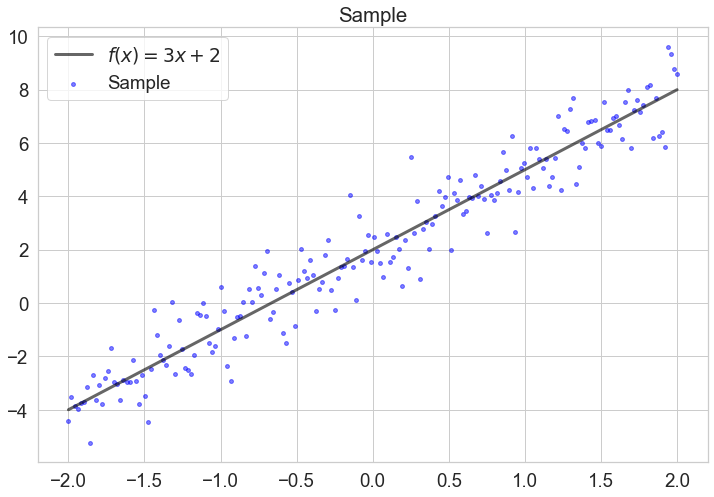

In [290]:
x_data, y_data = generate_data()

plt.figure(figsize=(12,8))
plt.title('Sample')
plt.scatter(x_data, y_data, s=15, alpha=0.5, color='blue', label='Sample')
plt.plot(x_data, f(x_data), color='black', lw=3, alpha=0.6, label=r'$f(x)=3x+2$')
plt.legend()
plt.show()

In [312]:
#--------------------------------------------------------------
# Modulo per una struttura lineare

class LinearModule(tf.Module):
    
    #costruttore 
    def __init__(self, **kwargs):
        super().__init__( **kwargs)
        self.w = tf.Variable(tf.random.normal([1], dtype=tf.float32), name='w')
        self.b = tf.Variable(tf.random.normal([1], dtype=tf.float32), name='b')
    
    #azione in chiamata della classe
    def __call__(self, x):
        return self.w * x + self.b
    
#---------------------------------------------------------------
# Funzione di Costo

def MSE(y_teo, y_est):
    # media ridotta a partire dai due vettori target_y e predicted_y
    return tf.reduce_mean(tf.square(y_teo-y_est))


In [356]:
my_linear = LinearModule()

Vediamo cosa ci propone la rete non allenata.

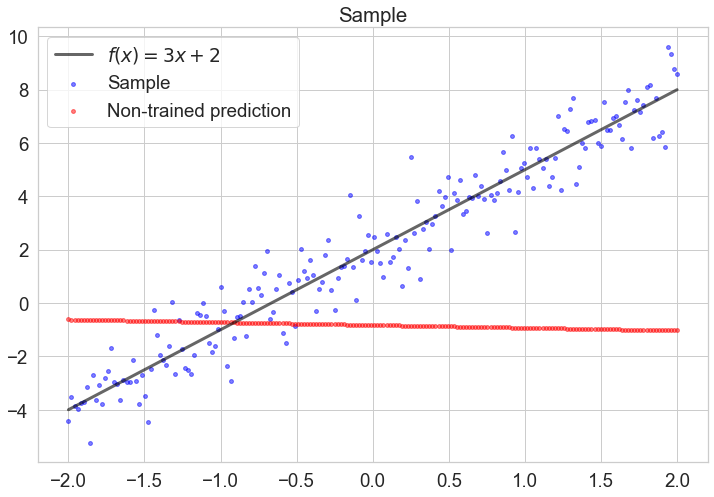

In [357]:
plt.figure(figsize=(12,8))
plt.title('Sample')
plt.scatter(x_data, y_data, s=15, alpha=0.5, color='blue', label='Sample')
plt.scatter(x_data, my_linear(x_data), s=15, alpha=0.5, color='red', label='Non-trained prediction')
plt.plot(x_data, f(x_data), color='black', lw=3, alpha=0.6, label=r'$f(x)=3x+2$')
plt.legend()
plt.show()

In [358]:
#------------------------------------------------------------------------------
# un passo del training
def train(model, x_train, y_train, learning_rate):
    
    with tf.GradientTape() as tape:
        current_loss = MSE(y_train, model(x_train))
        
    # calcola i gradienti rispetto ai due parametri
    dw, db = tape.gradient(current_loss, [model.w, model.b])

    # assign_sub ri-assegna il valore alla variabile di interesse (w o b \in model)
    # e ne sottrae il valore contenuto in (.) 
    # sto implementando in modo pratico la discesa del gradiente 
    model.w.assign_sub(learning_rate * dw)
    model.b.assign_sub(learning_rate * db)
    

#------------------------------------------------------------------------------
# il loop che costituisce l'intero training
def training(model, epochs, x_train, y_train):
        
    weights = []
    biases  = []
    

    for iepoch in range(epochs):
        # passo dell'addestramento
        train(model, x_train, y_train, learning_rate=0.1)

        # teniamo traccia dello storico di pesi e bias
        weights.append(model.w.numpy())
        biases.append(model.b.numpy())
        current_loss = MSE(y_train, model(x_train))

        # una stampa per vedere come vanno le cose
        print("Epoch ", iepoch, "/", epochs)
        print("w=", model.w.numpy(), " b=", model.b.numpy(), "loss=", current_loss.numpy()) 

    return weights, biases

        
#------------------------------------------------------------------------------
# funzione di controllo interessante copiata dal prof
def report(model, loss):
    return f"W = {model.w.numpy():1.2f}, b = {model.b.numpy():1.2f}, loss={loss:2.5f}"

In [359]:
weights, biases = training(my_linear, epochs=10, x_train=x_data, y_train=y_data)

Epoch  0 / 10
w= [0.7259631]  b= [-0.25441158] loss= 12.811041
Epoch  1 / 10
w= [1.3318155]  b= [0.19984329] loss= 7.777671
Epoch  2 / 10
w= [1.7744834]  b= [0.5632472] loss= 4.8934593
Epoch  3 / 10
w= [2.0979202]  b= [0.85397035] loss= 3.2275498
Epoch  4 / 10
w= [2.3342404]  b= [1.0865488] loss= 2.257454
Epoch  5 / 10
w= [2.5069084]  b= [1.2726116] loss= 1.687889
Epoch  6 / 10
w= [2.633069]  b= [1.4214618] loss= 1.350752
Epoch  7 / 10
w= [2.7252486]  b= [1.540542] loss= 1.1496036
Epoch  8 / 10
w= [2.7926]  b= [1.6358062] loss= 1.0286733
Epoch  9 / 10
w= [2.8418105]  b= [1.7120175] loss= 0.95544434


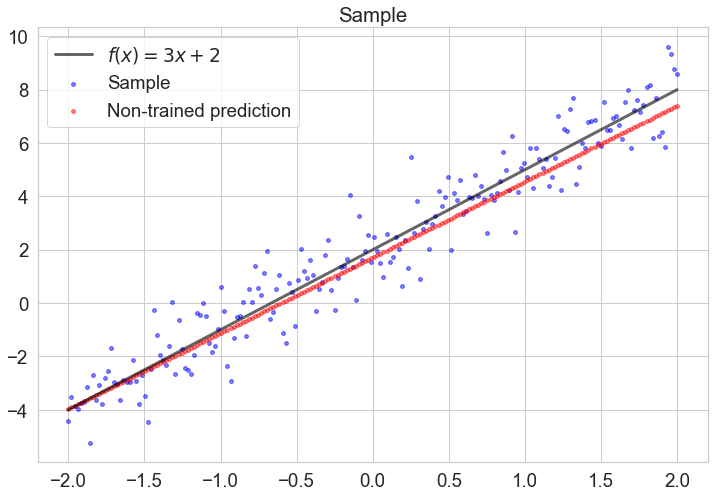

In [360]:
plt.figure(figsize=(12,8))
plt.title('Sample')
plt.scatter(x_data, y_data, s=15, alpha=0.5, color='blue', label='Sample')
plt.scatter(x_data, my_linear(x_data), s=15, alpha=0.5, color='red', label='Non-trained prediction')
plt.plot(x_data, f(x_data), color='black', lw=3, alpha=0.6, label=r'$f(x)=3x+2$')
plt.legend()
plt.show()

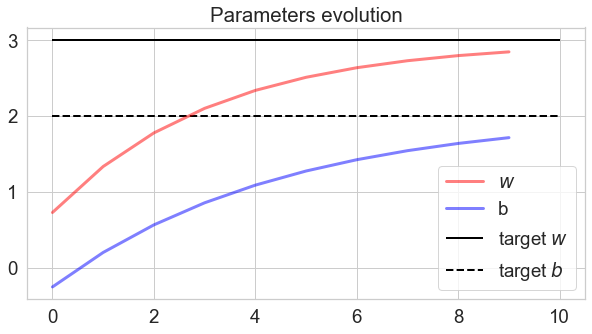

In [371]:
loops = np.arange(10)
plt.figure(figsize=(10,5))
plt.title('Parameters evolution')
plt.plot(loops, weights, label=r'$w$', lw=3, alpha=0.5, color='red')
plt.hlines(3, 0, 10, label=r'target $w$', lw=2, alpha=1, color='black')
plt.plot(loops, biases, label=r'b', lw=3, alpha=0.5, color='blue')
plt.hlines(2, 0, 10, label=r'target $b$', lw=2, alpha=1, color='black', ls='--')
plt.legend()
plt.show()